# User Days 2020 NWB Tutorial - Optical Physiology

## Introduction
In this tutorial, we will create fake data for a hypothetical optical physiology experiment with a freely moving animal. The types of data we will convert are:
* Subject (species, strain, age, etc.)
* Animal position
* Trials
* Acquired two-photon images
* Image segmentation (ROIs)
* Fluorescence and dF/F response

## Installing PyNWB
First, install PyNWB using pip or conda. You will need Python 3.5+ installed.
- `pip install pynwb`
- `conda install -c conda-forge pynwb`

## Set up the NWB file
An NWB file represents a single session of an experiment. Each file must have a session description, identifier, and session start time. Create a new `NWBFile` object with those and additional metadata. For all PyNWB constructors, we recommend using keyword arguments.

In [1]:
from pynwb import NWBFile
from datetime import datetime
from dateutil import tz

start_time = datetime(2018, 4, 25, 2, 30, 3, tzinfo=tz.gettz('US/Pacific'))

nwbfile = NWBFile(
    session_description='Mouse exploring an open field',
    identifier='Mouse5_Day3',
    session_start_time=start_time,
    session_id='session_1234',                                # optional
    experimenter='My Name',                                   # optional
    lab='My Lab Name',                                        # optional
    institution='University of My Institution',               # optional
    related_publications='DOI:10.1016/j.neuron.2016.12.011'   # optional
)
print(nwbfile)

root pynwb.file.NWBFile at 0x2703842882440
Fields:
  experimenter: ['My Name']
  file_create_date: [datetime.datetime(2020, 5, 5, 15, 20, 8, 496700, tzinfo=tzlocal())]
  identifier: Mouse5_Day3
  institution: University of My Institution
  lab: My Lab Name
  related_publications: ['DOI:10.1016/j.neuron.2016.12.011']
  session_description: Mouse exploring an open field
  session_id: session_1234
  session_start_time: 2018-04-25 02:30:03-07:00
  timestamps_reference_time: 2018-04-25 02:30:03-07:00



## Subject information
Create a `Subject` object to store information about the experimental subject, such as age, species, genotype, sex, and a freeform description. Then set `nwbfile.subject` to the `Subject` object.

<img src="images/subject.svg" width="200">

In [2]:
from pynwb.file import Subject

nwbfile.subject = Subject(
    age='9 months', 
    description='mouse 5',
    species='Mus musculus', 
    sex='M'
)

## SpatialSeries and Position
Many types of data can be stored in specialized classes in NWB. To store the spatial position of an animal, use the `SpatialSeries` and `Position` classes. 

`SpatialSeries` is a subclass of `TimeSeries`. `TimeSeries` is a common base class for measurements sampled over time, and provides fields for data and time (regularly or irregularly sampled).

<img src="images/Position.svg" width="500">

Create a `SpatialSeries` object named `'SpatialSeries'` with some fake data.

In [11]:
import numpy as np
from pynwb.behavior import SpatialSeries

# create fake data with shape (50, 2)
# the first dimension should always represent time
position_data = np.array([np.linspace(0, 10, 50),
                          np.linspace(0, 8, 50)]).T
position_timestamps = np.linspace(0, 50) / 200

spatial_series_obj = SpatialSeries(
    name='SpatialSeries', 
    description='(x,y) position in open field',
    data=position_data,
    timestamps=position_timestamps,
    reference_frame='(0,0) is bottom left corner'
)

You can print the `SpatialSeries` object to view its contents.

In [12]:
print(spatial_series_obj)

SpatialSeries pynwb.behavior.SpatialSeries at 0x2704151430472
Fields:
  comments: no comments
  conversion: 1.0
  data: [[ 0.          0.        ]
 [ 0.20408163  0.16326531]
 [ 0.40816327  0.32653061]
 [ 0.6122449   0.48979592]
 [ 0.81632653  0.65306122]
 [ 1.02040816  0.81632653]
 [ 1.2244898   0.97959184]
 [ 1.42857143  1.14285714]
 [ 1.63265306  1.30612245]
 [ 1.83673469  1.46938776]
 [ 2.04081633  1.63265306]
 [ 2.24489796  1.79591837]
 [ 2.44897959  1.95918367]
 [ 2.65306122  2.12244898]
 [ 2.85714286  2.28571429]
 [ 3.06122449  2.44897959]
 [ 3.26530612  2.6122449 ]
 [ 3.46938776  2.7755102 ]
 [ 3.67346939  2.93877551]
 [ 3.87755102  3.10204082]
 [ 4.08163265  3.26530612]
 [ 4.28571429  3.42857143]
 [ 4.48979592  3.59183673]
 [ 4.69387755  3.75510204]
 [ 4.89795918  3.91836735]
 [ 5.10204082  4.08163265]
 [ 5.30612245  4.24489796]
 [ 5.51020408  4.40816327]
 [ 5.71428571  4.57142857]
 [ 5.91836735  4.73469388]
 [ 6.12244898  4.89795918]
 [ 6.32653061  5.06122449]
 [ 6.53061224  5

To help data analysis and visualization tools know that this `SpatialSeries` object represents the position of the animal, store the `SpatialSeries` object inside of a `Position` object.

In [13]:
from pynwb.behavior import Position

position_obj = Position(spatial_series=spatial_series_obj)

NWB differentiates between raw, *acquired data*, which should never change, and *processed data*, which are the results of preprocessing algorithms and could change. Let's assume that the animal's position was computed from a video tracking algorithm, so it would be classified as processed data. Since processed data can be very diverse, NWB allows us to create processing modules, which are like folders, to store related processed data or data that comes from a single algorithm. 

Create a processing module for storing behavioral data in the `NWBFile` and add the `Position` object to the module.

In [14]:
behavior_module = nwbfile.create_processing_module(
    name='behavior', 
    description='processed behavioral data'
)
behavior_module.add(position_obj)

ValueError: 'behavior' already exists in 'root'

## Write to file

Now, write the NWB file that we have built so far.

In [15]:
from pynwb import NWBHDF5IO

with NWBHDF5IO('ecephys_tutorial.nwb', 'w') as io:
    io.write(nwbfile)

We can then read the file and print it to inspect its contents. We can also print the `SpatialSeries` data that you created by referencing the names of the objects in the hierarchy that contain it. The processing module called `'behavior'` contains our `Position` object. By default, the `Position` object is named `'Position'`. The `Position` object contains our `SpatialSeries` object named `'SpatialSeries'`.

In [16]:
with NWBHDF5IO('ecephys_tutorial.nwb', 'r') as io:
    read_nwbfile = io.read()
    print(read_nwbfile.processing['behavior']['Position']['SpatialSeries'])

SpatialSeries pynwb.behavior.SpatialSeries at 0x2704154617928
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (50, 2), type "<f8">
  description: (x,y) position in open field
  interval: 1
  reference_frame: (0,0) is bottom left corner
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (50,), type "<f8">
  timestamps_unit: seconds
  unit: meters



We can also use the HDFView tool to inspect the resulting NWB file.

<img src="images/position_hdfview1.png" width="400">

## Trials

`DynamicTable` objects are used to store tabular metadata throughout NWB, including trials, electrodes, and sorted units. They offer flexibility for tabular data by allowing required columns, optional columns, and custom columns.

<img src="images/Trials.svg" width="500">

Trials are stored in a `TimeIntervals` object which is a subclass of `DynamicTable`. Continue adding to our `NWBFile` by creating a new column for the trials table named `'correct'`, which will be a boolean array.

In [17]:
nwbfile.add_trial_column(name='correct', description='whether the trial was correct')
nwbfile.add_trial(start_time=1.0, stop_time=5.0, correct=True)
nwbfile.add_trial(start_time=6.0, stop_time=10.0, correct=False)

ValueError: column 'correct' already exists in DynamicTable 'trials'

## Optical physiology
Optical physiology results are written in four steps:
1. Create imaging plane
2. Add acquired two-photon images
3. Add image segmentation
4. Add fluorescence and dF/F responses

### Imaging Plane
First, we must create an `ImagingPlane` object, which will hold information about the area and method used to collect the optical imaging data. This first requires creation of a `Device` object for the microscope and an `OpticalChannel` object. 

<img src="images/ImagingPlane.svg" width="500">

Create a `Device` named `'Microscope'` using `nwbfile.create_device` and create an `OpticalChannel` named `'OpticalChannel'`. Then create an imaging plane named `'ImagingPlane'` using `nwbfile.create_imaging_plane`.

In [20]:
from pynwb.device import Device
from pynwb.ophys import OpticalChannel

device = nwbfile.create_device(
    name='Microscope', 
    description='The best two-photon microscope',
    manufacturer='The best microscope manufacturer'
)
optical_channel = OpticalChannel(
    name='OpticalChannel', 
    description='an optical channel', 
    emission_lambda=500.
)
imaging_plane = nwbfile.create_imaging_plane(
    name='ImagingPlane',
    optical_channel=optical_channel,
    imaging_rate=30.,
    description='a very interesting part of the brain',
    device=device,
    excitation_lambda=600.,
    indicator='GFP',
    location='V1',
    grid_spacing=[.01, .01],
    grid_spacing_unit='meters'
)

ValueError: 'Microscope' already exists in 'root'

### TwoPhotonSeries
Now that we have our `ImagingPlane`, we can create a `TwoPhotonSeries` object to hold our 2-photon imaging data. Here, we have two options. The first option is to supply the raw image data to PyNWB, using the `data` argument. The other option is the provide a path to the image files. These two options have trade-offs, so it is worth spending time considering how you want to store this data.

<img src="images/TwoPhotonSeries.svg" width="800">

In [21]:
from pynwb.ophys import TwoPhotonSeries

# using internal data. this data will be stored inside the NWB file
image_series1 = TwoPhotonSeries(
    name='TwoPhotonSeries1',
    data=np.ones((1000,100,100)),
    imaging_plane=imaging_plane,
    rate=1.0,
    unit='normalized amplitude'
)
nwbfile.add_acquisition(image_series1)

# using external data. just the file paths will be stored inside the NWB file
image_series2 = TwoPhotonSeries(
    name='TwoPhotonSeries2', 
    dimension=[100,100],
    external_file=['images.tiff'], 
    imaging_plane=imaging_plane,
    starting_frame=[0], 
    format='external', 
    starting_time=0.0, 
    rate=1.0
)
nwbfile.add_acquisition(image_series2)

### Plane Segmentation
The `PlaneSegmentation` class stores the detected regions of interest in the `TwoPhotonSeries` data. `PlaneSegmentation` is a subclass of `DynamicTable`, where each row represents a single region of interest (ROI). 

The `ImageSegmentation` class can contain multiple `PlaneSegmentation` objects so that we can store the results of different segmentation algorithms or different segmentation classes (e.g., cell segmentation and neuropil segmentation).

<img src="images/planesegmentation.svg" width="1000">

In [23]:
from pynwb.ophys import ImageSegmentation

img_seg = ImageSegmentation()
ps = img_seg.create_plane_segmentation(
    name='PlaneSegmentation',
    description='output from segmenting my favorite imaging plane',
    imaging_plane=imaging_plane,
    reference_images=image_series1  # optional
)
ophys_module = nwbfile.create_processing_module(
    name='ophys', 
    description='optical physiology processed data'
)
ophys_module.add(img_seg)

ImageSegmentation pynwb.ophys.ImageSegmentation at 0x2704156686728
Fields:
  plane_segmentations: {
    PlaneSegmentation <class 'pynwb.ophys.PlaneSegmentation'>
  }

### Regions Of Interest (ROIs)
#### Image masks
You may add ROIs using an image mask or using a pixel mask. An image mask is an array that is the same size as a single frame of the `TwoPhotonSeries`, and indicates where a single region of interest is. This image mask may be boolean or continuous between 0 and 1.

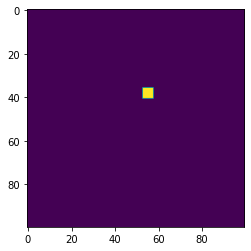

In [24]:
for _ in range(30):
    image_mask = np.zeros((100, 100))
    
    # randomly generate example image masks
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)
    image_mask[x:x+5, y:y+5] = 1
    
    # add image mask to plane segmentation
    ps.add_roi(image_mask=image_mask)
    
# show one of the image masks
import matplotlib.pyplot as plt
plt.imshow(image_mask)

#### Pixel masks
Alternatively, you could define ROIs using pixel mask, which defines each pixel individually with (x, y, val). All undefined pixels are assumed to be 0. But you need to decide and keep it consistent. You cannot add some by `image_mask` and some by `pixel_mask`.

In [13]:
ps2 = img_seg.create_plane_segmentation(
    name='PlaneSegmentation2',
    description='output from segmenting my favorite imaging plane',
    imaging_plane=imaging_plane,
    reference_images=image_series1  # optional
)

for _ in range(30):
    # randomly generate example image masks
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)
    
    pixel_mask = []
    for ix in range(x, x+5):
        for iy in range(y, y+5):
            pixel_mask.append((ix, iy, 1))
    
    # add pixel mask to plane segmentation
    ps2.add_roi(pixel_mask=pixel_mask)

## Storing fluorescence measurements

Now that ROIs are stored, you can store fluorescence dF/F data for these regions of interest. This type of data is stored using the `RoiResponseSeries` class. You will not need to instantiate this class directly to create objects of this type, but it is worth noting that this is the class you will work with after you read data back in.

<img src="images/roiresponseseries.svg" width="1200">


First, create a data interface to store this data in

In [14]:
from pynwb.ophys import Fluorescence

fl = Fluorescence()
ophys_module.add(fl)

Fluorescence pynwb.ophys.Fluorescence at 0x1837325224968
Fields:

You will need to provide a reference to the ROIs that you will be storing data for. This is done using a `DynamicTableRegion`, which can be created with `PlaneSegmentation.create_roi_table_region`.

In [15]:
rt_region = ps.create_roi_table_region(
    region=[0,1],
    description='the first of two ROIs'
)

Now that you have a `DynamicTableRegion`, you can create an `RoiResponseSeries`.

In [16]:
roi_response_series = fl.create_roi_response_series(
    name='RoiResponseSeries',
    data=np.ones((50,2)),
    rois=rt_region,
    unit='lumens',
    rate=30.
)

## Write the file

In [17]:
with NWBHDF5IO('ophys_tutorial.nwb', 'w') as io:
    io.write(nwbfile)

## Reading NWB data
Data arrays are read passively from the file. Calling `TimeSeries.data` does not read the data values, but presents an `h5py` object that can be indexed to read data. Index this array just like a numpy array to read only a specific section of the array, or use the `[:]` operator to read the entire thing.

In [18]:
with NWBHDF5IO('ophys_tutorial.nwb', 'r') as io:
    read_nwbfile = io.read()

    print(read_nwbfile.acquisition['TwoPhotonSeries1'])
    print(read_nwbfile.processing['ophys']['Fluorescence']['RoiResponseSeries'].data[:])

TwoPhotonSeries1 pynwb.ophys.TwoPhotonSeries at 0x1837322748232
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1000, 100, 100), type "<f8">
  description: no description
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x1837322749960
Fields:
  conversion: 1.0
  description: a very interesting part of the brain
  device: Microscope001 pynwb.device.Device at 0x1837325225288
  excitation_lambda: 600.0
  imaging_rate: 30.0
  indicator: GFP
  location: V1
  optical_channel: (
    OpticalChannel <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  rate: 1.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: normalized amplitude

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.

# Learn more!

## Python tutorials
### See our tutorials for more details about your data type:
* [Extracellular electrophysiology](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ecephys.html#sphx-glr-tutorials-domain-ecephys-py)
* [Calcium imaging](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ophys.html#sphx-glr-tutorials-domain-ophys-py)
* [Intracellular electrophysiology](https://pynwb.readthedocs.io/en/stable/tutorials/domain/icephys.html#sphx-glr-tutorials-domain-icephys-py)

### Check out other tutorials that teach advanced NWB topics:
* [Iterative data write](https://pynwb.readthedocs.io/en/stable/tutorials/general/iterative_write.html#sphx-glr-tutorials-general-iterative-write-py)
* [Extensions](https://pynwb.readthedocs.io/en/stable/tutorials/general/extensions.html#sphx-glr-tutorials-general-extensions-py)
* [Advanced HDF5 I/O](https://pynwb.readthedocs.io/en/stable/tutorials/general/advanced_hdf5_io.html#sphx-glr-tutorials-general-advanced-hdf5-io-py)


## MATLAB tutorials
* [Extracellular electrophysiology](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/ecephys.html)
* [Calcium imaging](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/ophys.html)
* [Intracellular electrophysiology](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/icephys.html)